In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [2]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [4]:
v = stepmodel.read_json(model_path + 'de_volumes')
sm.volumes = v.volumes

In [5]:
sm.segments = [c for c in sm.volumes.columns if c not in ['origin', 'destination']]

In [6]:
road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [57]:
car = stepmodel.read_json(model_path + 'de_road_los')
pt = stepmodel.read_json(model_path + 'de_pt_los')

In [58]:
# Rename columns that were confused through json export
column_dict = {"('"+seg+"', 'probability')": (seg, 'probability') for seg in sm.segments}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [9]:
# Load logit step probabilities to enrich LoS tables
'''logit = stepmodel.read_json(model_path + 'de_logit')
probs = logit.probabilities.set_index(['origin', 'destination', 'segment'])[
    ['walk', 'car', 'air', 'bus', 'coach', 'rail_short', 'rail_long']
].stack().rename('probability').unstack('segment')
probs.index.rename(['origin', 'destination', 'route_type'], inplace=True)

sm.pt_los = pt.pt_los.merge(probs, how='left',
    on=['origin', 'destination', 'route_type']
).rename(columns={seg: (seg, 'probability') for seg in sm.segments})

sm.car_los = car.car_los.merge(probs, how='left',
    on=['origin', 'destination', 'route_type']
).rename(columns={seg: (seg, 'probability') for seg in sm.segments})'''
print('This step is necessary if enriched LoS tables were not saved in the logit step')

This step is necessary if enriched LoS tables were not saved in the logit step


In [59]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [11]:
sm.pt_los.sample(2)

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,path,...,"('Fz1', 'utility')","('Fz2', 'utility')","('Fz3', 'utility')","('Fz4', 'utility')","('Fz6', 'utility')","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
index,,,,,,,,,,,,,,,,,,,,,
245559,1353,0.000000,DED45,0,5280,431631,"(r_s_117745, r_s_117746, r_s_117751, r_s_11775...",4,DE271,None,...,-6.171919,-2.582780,-5.835006,-3.331851,-4.582648,0.006558,0.002258,0.008306,0.065554,0.029103
494502,2686,0.768343,DE928,0,660,456006,"(bus_1842502, bus_629573, bus_1740945, bus_253...",9,DEA26,None,...,-3.145240,-0.006005,-3.419385,-3.542798,-3.468826,0.235315,0.478961,0.146232,0.034346,0.081910


In [12]:
# Repair route_types if they are the same as route_type
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(lambda p: tuple(p))
if len(sm.pt_los['route_types'].unique())==len(sm.pt_los['route_type'].unique()):
    type_dict = sm.links['route_type'].to_dict()
    sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                                for l in list(sm.pt_los['link_path'])]

In [60]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

## Assignment

In [61]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [05:16<00:00, 63.32s/it]


In [62]:
# Generate road_links loads from car_los and volumes
sm.segmented_car_assignment()

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.54s/it]


In [63]:
# Assign volumes to LoS path table
sm.compute_los_volume(keep_segments=True)

## Results

In [64]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price,"(load, bus)","(load, rail_long)","(load, rail_short)","(load, coach)","(load, air)","(load, walk)",load
index,,,,,,,,,,,,,,,,,,
bus_732203,DE40H_bus_0,DE300_bus_0,bus,"LINESTRING (13.27580 52.07253, 13.30549 52.46445)",1,bus_18765,240,bus_100334,48808,600,0.0,6677.579964,0.0,1637.679495,50.642287,0.0,0.0,8365.901745


In [65]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,geometry,maxspeed,lanes,highway,length,"(Fz1, car)","(Fz2, car)","(Fz3, car)","(Fz4, car)","(Fz6, car)","(all, car)"
index,,,,,,,,,,,,,
rl_473398,450182,470583,"LINESTRING (8.51434 49.90563, 8.51697 49.90565)",70,"[4, 2]",primary,189,1.182812e+07,1.665392e+06,1.003366e+07,5.637382e+06,1.849311e+07,4.765766e+07


In [66]:
sm.los.sample()

,index,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,...,"(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)",Fz1,Fz2,Fz3,Fz4,Fz6,volume
288387,288387,3356,0.027583,DEA15,0,8280,905740,"(r_s_90545, r_s_141808, r_s_141816, r_s_153187...",7,DE40A,...,0.470289,0.240381,0.117989,0.153895,0.0,0.0,0.0,44.481759,126.03991,170.521669


<AxesSubplot:>

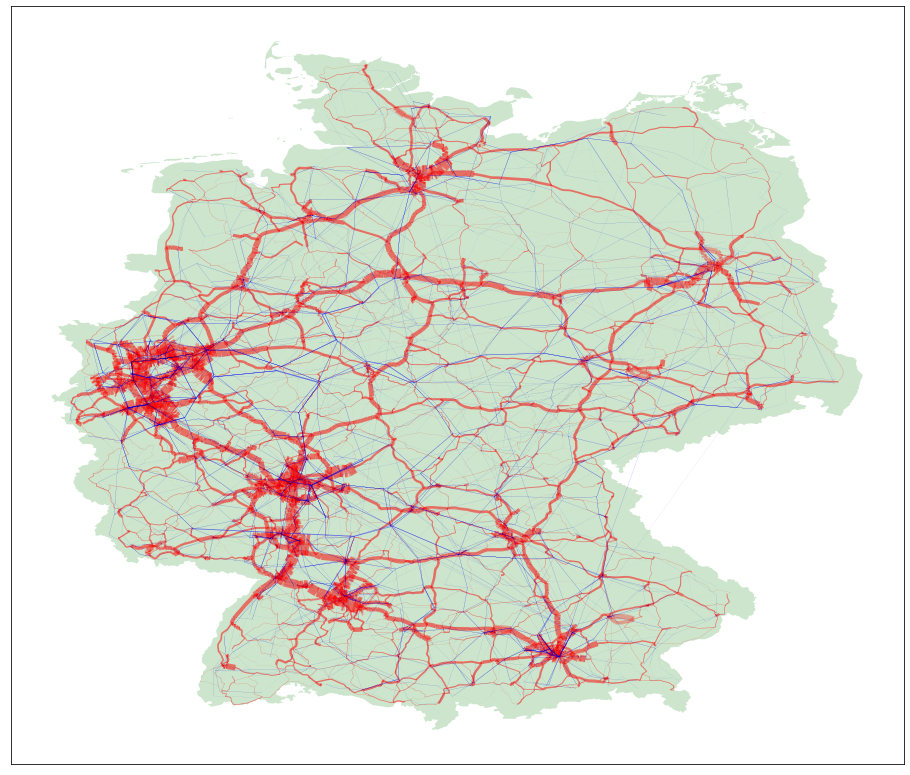

In [20]:
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

### Validation

In [67]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

In [68]:
diff['diff'].mean()

1.0260782350512601e-07

<AxesSubplot:>

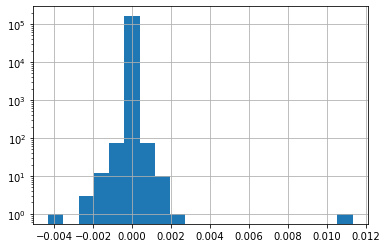

In [69]:
diff['diff'].hist(bins=20, log=True)

In [70]:
# Summary of LoS table
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # hours per trip
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per trip

In [71]:
od_sum.sample()

segment                    Fz1                                     \
sum                     volume     price     time in_vehicle_time   
origin destination mode                                             
DE80N  DEE07       bus     0.0  2.716718  0.75238      326.006118   

segment                                              Fz2                     \
sum                             length ntransfers volume    price      time   
origin destination mode                                                       
DE80N  DEE07       bus   218123.222484   2.716718    0.0  3.94208  1.091737   

segment                                  ...       Fz6                  \
sum                     in_vehicle_time  ...      time in_vehicle_time   
origin destination mode                  ...                             
DE80N  DEE07       bus       473.049601  ...  0.261315       113.22787   

segment                                                  root            \
sum                            length ntransfers       volume     price   
origin destination mode                                                   
DE80N  DEE07       bus   75758.172872   0.943566  1696.418292  0.928674   

segment                                                                     
sum                          time in_vehicle_time        length ntransfers  
origin destination mode                                                     
DE80N  DEE07       bus   0.257191      111.440904  74562.555291   0.928674  

[1 rows x 36 columns]

In [72]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

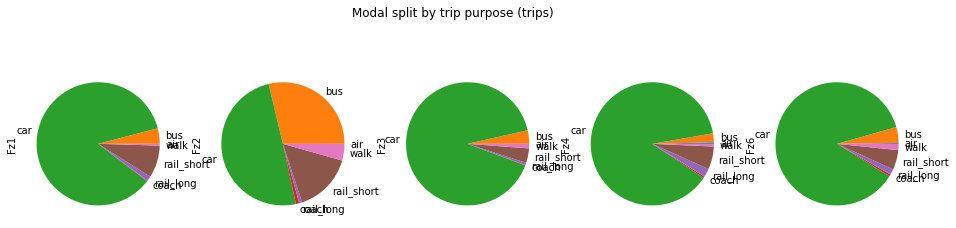

In [73]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

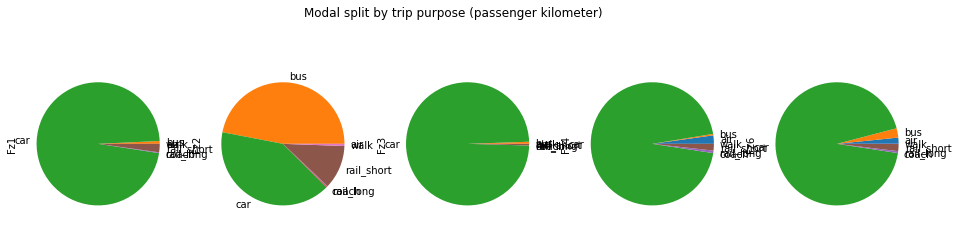

In [74]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

Volumes by mode and distance class


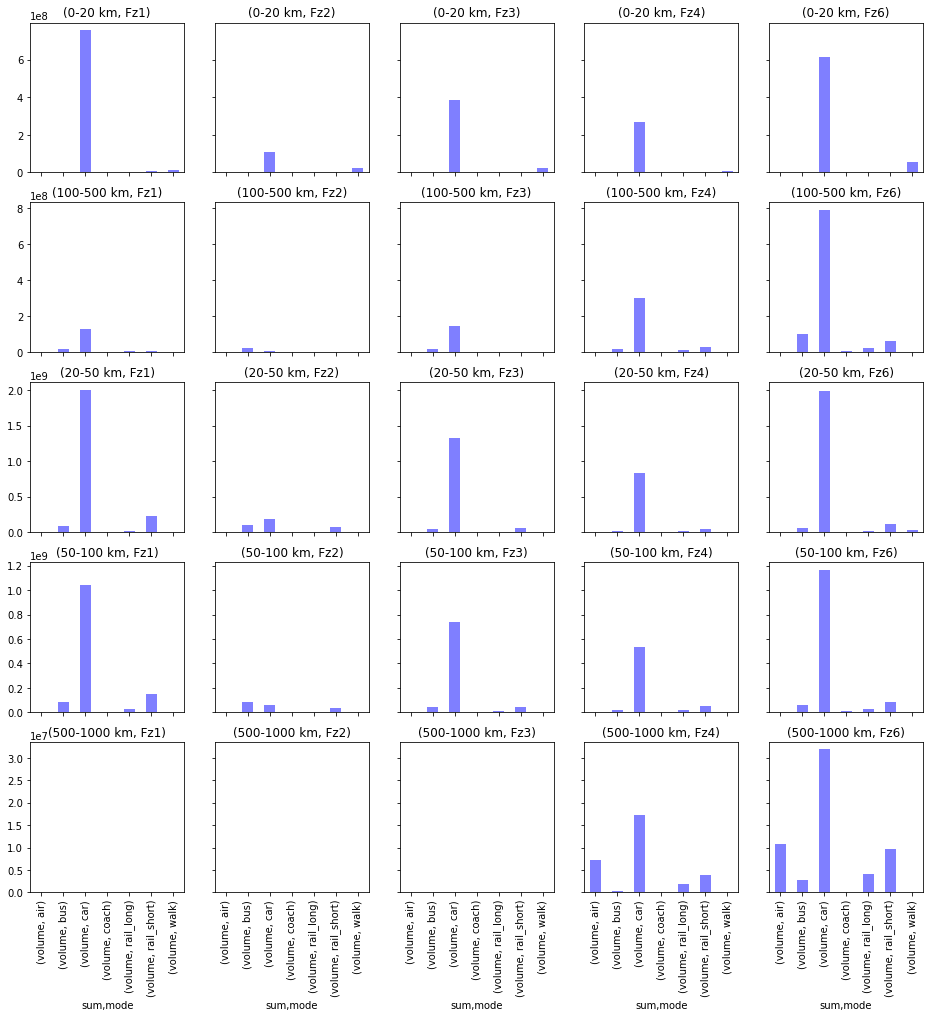

In [75]:
od = od_sum[[(seg, 'volume') for seg in sm.segments]].unstack('mode')
bins = [0, 20, 50, 100, 500, 1000]
distances = sm.car_los.drop_duplicates(['origin', 'destination']).set_index(
    ['origin', 'destination'])['length'] / 1000
od['bins'] = pd.cut(od.merge(distances, how='left', left_index=True,
                             right_index=True)['length'], bins=bins,
                    labels=['{}-{} km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)])
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,16), sharex='all', sharey='row')
od.sort_values('bins').groupby('bins').sum(axis=0).stack('segment').T.plot.bar(
    ax=ax, subplots=True, legend=False, color='blue', alpha=0.5)
print('Volumes by mode and distance class')

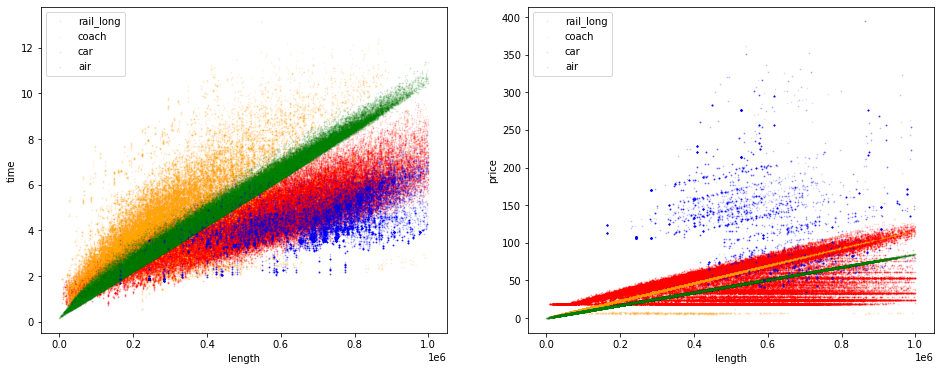

In [56]:
# Why is there so few long-distance PT?
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
c_dict = {'rail_long': 'red', 'coach': 'orange', 'car': 'green', 'air': 'blue'}
for m in c_dict.keys():
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[0], kind='scatter', x='length', y='time', s=.5, c=c_dict[m], alpha=.5, label=m)
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[1], kind='scatter', x='length', y='price', s=.5, c=c_dict[m], alpha=.5, label=m)
plt.legend()

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [76]:
# Keep only the sum of all purposes
od = od_sum.loc[:, 'root']

In [77]:
# Aggregated modal split in million pkm
od.groupby(level=2).sum(axis=1)['pkm'] / 1e6

mode
air             7401.848268
bus            16824.600689
car           635217.354041
coach             93.327110
rail_long       2567.026695
rail_short     12825.134016
walk             296.948835
Name: pkm, dtype: float64

In [78]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3]
od['destination'] = od['destination'].str[:3]
od = od.groupby(['origin', 'destination', 'mode']).sum()

In [79]:
with pd.ExcelWriter(output_path + 'stacks.xlsx') as writer:  
    od.to_excel(writer, sheet_name='od_sum')

## Save model

In [43]:
sm.to_json(model_path + 'de_assignment', only_attributes=[
    'loaded_links', 'loaded_nodes', 'road_links', 'los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [04:09<00:00,  6.55s/it]
